In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
from read_data import create_df, create_dfV2, create_df_old
import numpy as np

pd.set_option('display.max_rows', 100)

# Generic plotting configurations
plt.rcParams['figure.figsize'] = [10, 8]
plt.style.use('ggplot')

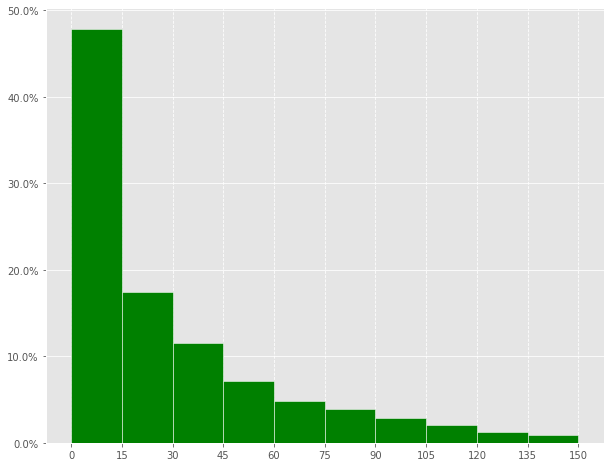

In [2]:
# Select which experiments to plot
EXP = 'G10'
NREP = range(0,15)
NROB = [10, 20, 30]

# Collect data
df = create_df(EXP, 'block')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")

# Create figure
bins = range(0,165,15)
xticks = range(0,165,15)

ax = plt.axes()
ax.grid(axis='x', linestyle='--') # vertical lines
ax.set_xticks(xticks) 
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))

hist, bins = np.histogram(df['TELAPSED'], bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='w')

# ax = df['TELAPSED'].plot.hist(color='green', bins=bins, xticks=xticks)

plt.show()

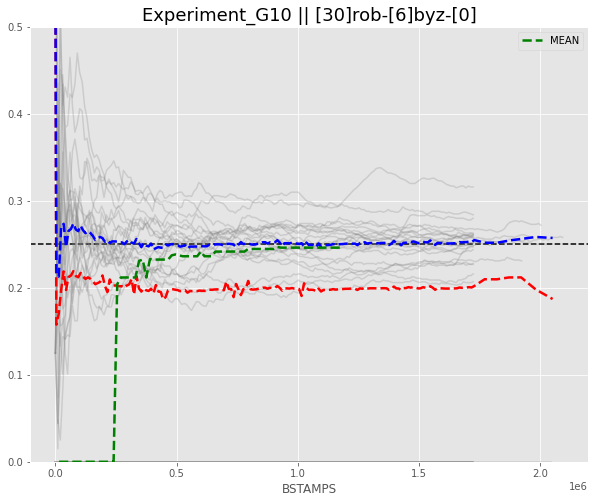

In [3]:
# Select which experiment to plot
EXP = 'G10'
NREP = [0]
NROB = [30]
NBYZ = [6]

# Collect data
df = create_df(EXP, 'estimate')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")

# Create figure
ax = plt.axes()

# Plot actual value
handle1 = plt.axhline(0.25, color='k', linestyle='--', linewidth=1.5)
# Plot each robot estimate
handle2 = df.set_index(['TIME']).groupby(['ID'])['ESTIMATE'].plot(color='grey', alpha=0.25)
handle2.label = 'Robot Estimates'
# Plot mean of robot estimates 
handle3 = df[['TIME', 'ESTIMATE']].sort_values('TIME').reset_index().groupby(df.index // NROB).mean().set_index('TIME')['ESTIMATE'].plot(color='r', linestyle='--', linewidth=2.5)
handle3.label = 'Robot Estimates (Mean, incl. Byzantines)'
# Plot excluding Byzantines
handle4 = df[['TIME', 'ESTIMATE']].sort_values('TIME').reset_index().replace(0,np.NaN).groupby(df.index // NROB).mean().set_index('TIME')['ESTIMATE'].plot(color='b', linestyle='--', linewidth=2.5)
handle4.label = 'Robot Estimates (Mean, excl. Byzantines)'

df = create_df(EXP, 'sc')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")

df['BSTAMPS'] = df['BLOCK'].mul(15*1000) 
df['MEAN'] = df['MEAN'].div(10000000) 
handle5 = df.groupby(['BLOCK'])[['BSTAMPS', 'MEAN']].max().set_index('BSTAMPS').plot(ax=ax, color='g', linestyle='--', linewidth=2.5)
handle5.label = 'Blockchain Estimate'

# Edit figure looks
ax.set_ylim(ymin=0, ymax=0.5)
ax.set_title('Experiment_{} || {}rob-{}byz-{}'.format(EXP, NROB, NBYZ, NREP), fontsize=18)
# ax.legend()
plt.show()

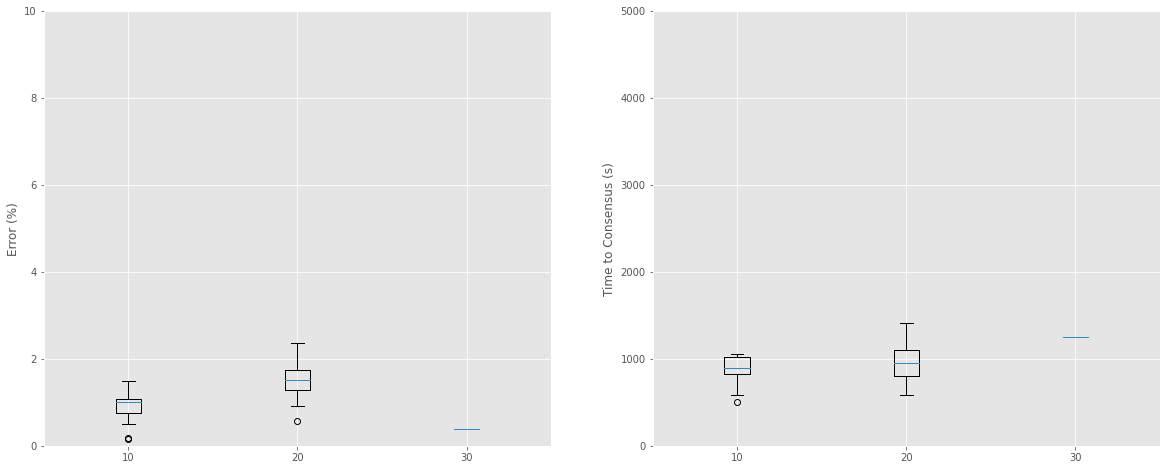

In [10]:
# Select which experiment to plot
EXP = 'G10'
NREP = range(0,15)
NROB = [10, 20, 30]

# Collect data
df = create_df(EXP, 'sc')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")

# Create figure
fig, ax = plt.subplots(1,2, figsize=(20, 8))

# Big group for each box: Number of robots
boxes = df.groupby('NROB')

for x, box in boxes:
    errors = box.sort_values('TIME').groupby('NREP')['MEAN'].agg(['last']) # not 100% correct yet
    errors = errors.div(10000000).sub(0.25).abs().mul(100)

    cts = box[(box['C?']==True)].sort_values('TIME').groupby('NREP')['TIME'].agg(['first'])
    cts = cts.div(1000)
    
    # Plot boxplots for errors
    ax[0].boxplot(errors['last'], positions=[x/10])
    # Plot boxplots for consensus times
    ax[1].boxplot(cts['first'], positions=[x/10])
    
# Edit figure looks
ax[0].set_ylim(ymin=0, ymax=10)
ax[1].set_ylim(ymin=0, ymax=5000)
ax[0].set_xticklabels(NROB)
ax[1].set_xticklabels(NROB)
ax[0].set_ylabel('Error (%)')
ax[1].set_ylabel('Time to Consensus (s)')
plt.show()


,ID,TIME,BLOCK,BALANCE,UBI,PAY,#ROBOT,MEAN,#VOTES,#OKVOTES,#MYVOTES,#MYOKVOTES,R?,C?,NREP,NBYZ,NROB
10769,105,193563,11,21.0,0,40,10,2266264,9,9,1,1,False,False,5,2,10
10808,106,191144,11,21.0,0,40,10,2266264,9,9,1,1,False,False,5,2,10
10851,108,192857,11,21.0,0,40,10,2266264,9,9,1,1,False,False,5,2,10
10925,101,224880,11,21.0,0,40,10,2266264,9,9,1,1,False,False,5,2,10
10952,117,187818,11,21.0,0,0,9,0,9,0,1,0,True,False,5,2,10
10983,103,189971,11,61.0,0,0,10,0,9,0,0,0,True,False,5,2,10
10984,103,194832,11,61.0,0,0,10,0,9,0,0,0,False,False,5,2,10
11024,120,177315,11,21.0,0,0,9,0,9,0,1,0,True,False,5,2,10
11067,104,174512,11,1.0,20,0,10,0,9,0,1,0,True,False,5,2,10
11068,104,178443,11,1.0,20,0,9,0,9,0,1,0,True,False,5,2,10


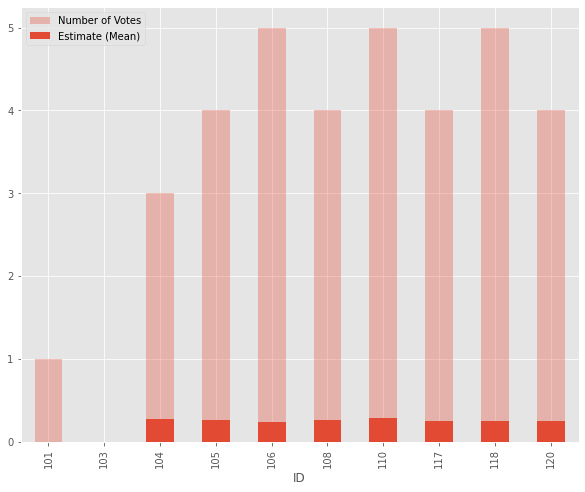

In [5]:
# Select which experiment to plot
EXP = 'G10'
NREP = [5]
NROB = [10]

# Collect data
df = create_df(EXP, 'sc')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")
display(df.query('BLOCK==11'))

# Create figure
ax = plt.axes()

df.set_index(['ID']).groupby(['ID'])['#MYOKVOTES'].agg(['max']).plot.bar(ax=ax, alpha=0.33)

# Collect data
df = create_df(EXP, 'estimate')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")

df.set_index(['ID']).groupby(['ID'])['ESTIMATE'].agg(['mean']).plot.bar(ax=ax)

plt.legend(['Number of Votes', 'Estimate (Mean)'])
plt.show()

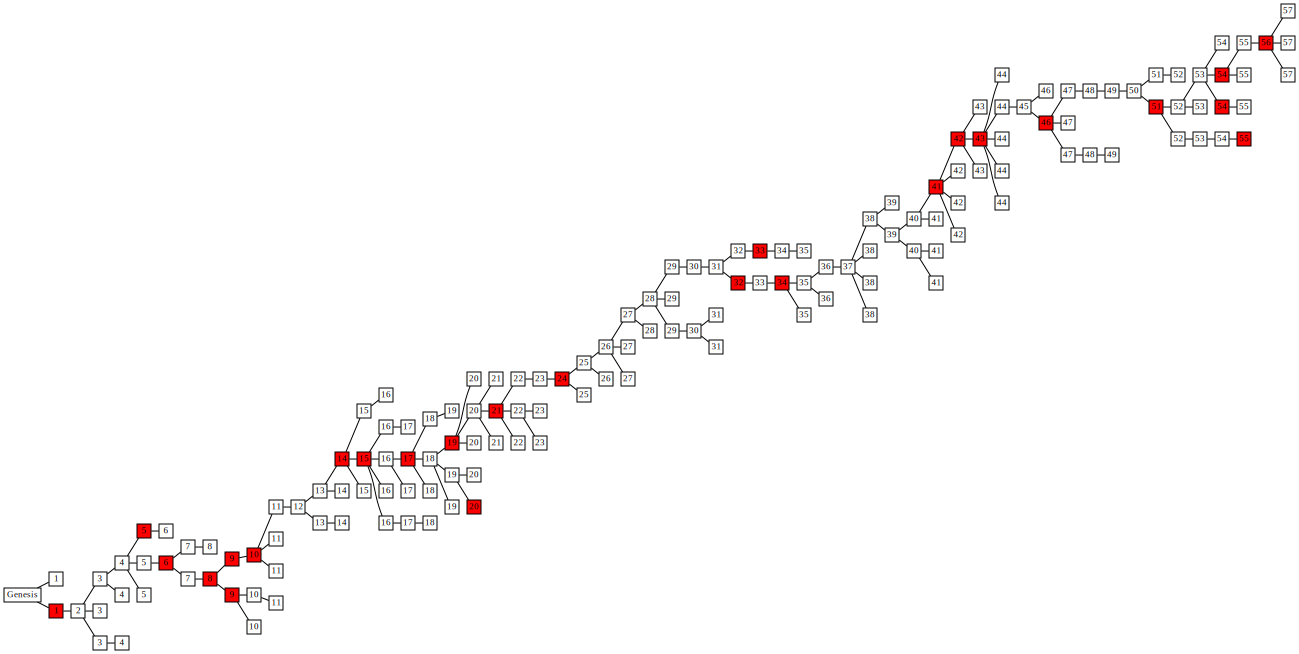

In [100]:
import graphviz
# Default settings for blockchain viz
blockchain = graphviz.Digraph(comment='The Round Table', 
                              edge_attr={'arrowhead':'none'},
                              node_attr={'shape': 'box', 'margin': '0', 'fontsize':'9', 'height':'0.2', 'width':'0.2'}, 
                              graph_attr={'rankdir': 'LR', 'ranksep': '0.1' })

# Select which experiment to plot
EXP = 'G10'
NREP = [1]
NROB = [10]

# Collect data
df = create_df(EXP, 'block')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")

# Remove duplicate blocks and find max index
df_blocks = df.drop_duplicates('HASH')
max_block = df['BLOCK'].max()
genesis = df['PHASH'].iloc[0]
blockchain.node(str(genesis), 'Genesis')

# Construct digraph
df_blocks.apply(lambda row : blockchain.node(str(row['HASH']), str(row['BLOCK'])), axis = 1)
df_blocks.apply(lambda row : blockchain.edge(str(row['PHASH']), str(row['HASH'])), axis = 1)

# Do something cool? Idk, maybe color blocks sealed by prefered in red. 
df_blocks.query('DIFF==2').apply(lambda row : blockchain.node(row['HASH'], style='filled', fillcolor='red'), axis = 1)

blockchain